# Project 1 Jupyter Notebook: Shifting Social Roles

## Group 8: Gary Becker

Authors: Amanda Edwards, Ash Htet, Layla Jurow, Mattea Kalpakoff, Zitong Xu

In this Jupyter Notebook, we will be introducing population functions, population pyramids, and graphs in order to understand the trends that have led to shifting social roles in the United States and the consequent impact on population growth. We have incorporated data from the WBData Population  and  Federal Reserve Economic datasets.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import logging
import plotly.graph_objects as go
import sys
from pathlib import Path
import plotly.express as px
import statsmodels.formula.api as smf

# import wbdata...
try:
    import wbdata
    print("wbdata is already installed! Skipping download.")

# If the computer says can't, THEN install it.
except ImportError:
    print("wbdata not found. Installing it for you now...")
    !{sys.executable} -m pip install wbdata
    import wbdata
    print("Done! wbdata is ready to use.")
logging.getLogger('shelved_cache').setLevel(logging.ERROR)
print("Libraries loaded.")

wbdata not found. Installing it for you now...
  Using cached wbdata-1.1.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached dateparser-1.3.0-py3-none-any.whl.metadata (30 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
Using cached wbdata-1.1.0-py3-none-any.whl (18 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached dateparser-1.3.0-py3-none-any.whl (318 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached tzlocal-5.3.1-py3-none-any.whl (18 kB)
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachet

Key '5470054155536092500' not in persistent cache.
Key '-5313500433190532682' not in persistent cache.
Key '-2502497045673246715' not in persistent cache.
Key '3932649152150695703' not in persistent cache.
Key '-6615010613158664429' not in persistent cache.
Key '-7815621352691328900' not in persistent cache.
Key '2469735544378327544' not in persistent cache.
Key '7189415798458876284' not in persistent cache.
Key '5988805058926211813' not in persistent cache.
Key '1753779157808640955' not in persistent cache.
Key '3062018992450922144' not in persistent cache.
Key '-6695936423881893195' not in persistent cache.
Key '8060516393873888595' not in persistent cache.
Key '8223847875740685865' not in persistent cache.
Key '62460699100790693' not in persistent cache.
Key '6143774071620248097' not in persistent cache.
Key '8693378142156510327' not in persistent cache.
Key '5003086886202740501' not in persistent cache.
Key '1501456409528237194' not in persistent cache.
Key '2118616605876306803' no

Done! wbdata is ready to use.
Libraries loaded.


## Background

### Shifting Family Dynamics

Family dynamics in the United States have shifted alongside declining fertility and changing caregiving norms. Although Americans are having fewer children, parents—especially fathers—are spending more time on child care than previous generations. Time-use data show a substantial increase in fathers’ involvement in both child care and household labor, particularly since the COVID-19 pandemic, narrowing gender gaps in domestic work.

These changes reflect the evolution of household social roles, as caregiving is shared rather than just a responsibility for women. As domestic responsibilities become more evenly distributed, women have more freedom to choose what roles they take on, influencing workforce trends. The following graph shows labor force participation rates over time for men, women, and the total population, providing context for how these social shifts align with changes in workforce behavior.

Saved:
 - lfpr_us_monthly_clean.csv
 - lfpr_us_annual_clean.csv


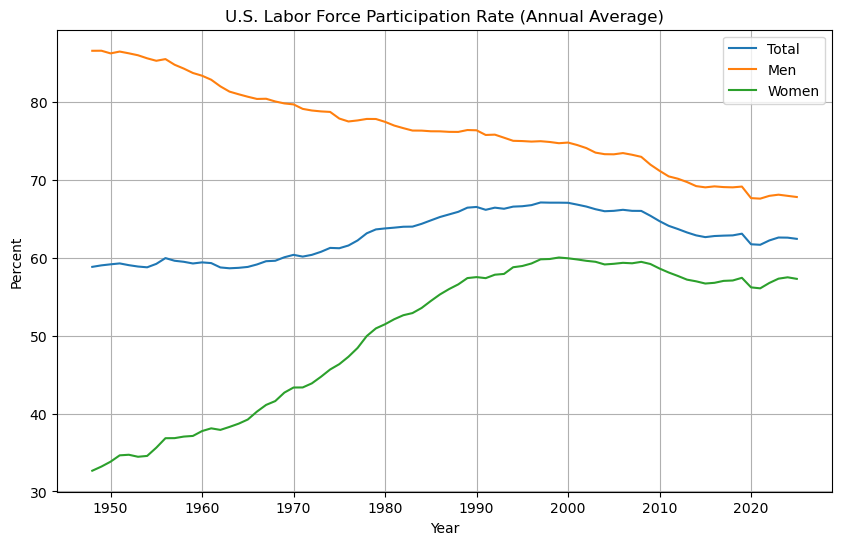

In [2]:
DATA_DIR = Path(".")  
FILES = {
    "Total": "CIVPART.csv",
    "Men": "LNS11300001.csv",
    "Women": "LNS11300002.csv",
}

total_raw = pd.read_csv(DATA_DIR / FILES["Total"])
men_raw   = pd.read_csv(DATA_DIR / FILES["Men"])
women_raw = pd.read_csv(DATA_DIR / FILES["Women"])
                       
def standardize_lfpr(df: pd.DataFrame, series_name: str) -> pd.DataFrame:
   
    df = df.copy()

    if "observation_date" in df.columns:
        value_cols = [c for c in df.columns if c != "observation_date"]
        if len(value_cols) != 1:
            raise ValueError(
                f"{series_name}: expected 1 value column besides observation_date, found {value_cols}"
            )
        val_col = value_cols[0]
        out = df.rename(columns={"observation_date": "date", val_col: series_name})
        out["date"] = pd.to_datetime(out["date"])
        out[series_name] = pd.to_numeric(out[series_name], errors="coerce")
        return out[["date", series_name]].sort_values("date").reset_index(drop=True)

total = standardize_lfpr(total_raw, "Total")
men   = standardize_lfpr(men_raw, "Men")
women = standardize_lfpr(women_raw, "Women")

lfpr_monthly = total.merge(men, on="date", how="inner").merge(women, on="date", how="inner")
lfpr_annual = (
    lfpr_monthly.assign(year=lfpr_monthly["date"].dt.year)
    .groupby("year")[["Total", "Men", "Women"]]
    .mean()
    .reset_index()
    .sort_values("year")
    .reset_index(drop=True)
)

lfpr_monthly.to_csv(DATA_DIR / "lfpr_us_monthly_clean.csv", index=False)
lfpr_annual.to_csv(DATA_DIR / "lfpr_us_annual_clean.csv", index=False)

print("Saved:")
print(" -", DATA_DIR / "lfpr_us_monthly_clean.csv")
print(" -", DATA_DIR / "lfpr_us_annual_clean.csv")

plt.figure(figsize=(10, 6))
plt.plot(lfpr_annual["year"], lfpr_annual["Total"], label="Total")
plt.plot(lfpr_annual["year"], lfpr_annual["Men"], label="Men")
plt.plot(lfpr_annual["year"], lfpr_annual["Women"], label="Women")
plt.title("U.S. Labor Force Participation Rate (Annual Average)")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.grid(True)
plt.legend()
plt.show()

In addition to creating this graph, our team also constructed unit tests to ensure our code worked, and defined a function that would make accessing the information in the graph much simpler. We will call this function later on in the project to understand what year data contains significant shifts in the labor force. The function will respond to queries of the following form:

"In [year] what was the labor force participation rate (%) for [Total/Men/Women]?"

In [3]:
assert not lfpr_monthly.empty, "Monthly LFPR dataset is empty after merge"
assert not lfpr_annual.empty, "Annual LFPR dataset is empty after aggregation"

assert lfpr_annual["year"].is_monotonic_increasing, "Years should be increasing"

assert lfpr_annual[["Total", "Men", "Women"]].notna().all().all(), "Missing values in annual LFPR"

bounds_ok = ((lfpr_annual[["Total", "Men", "Women"]] >= 0) &
             (lfpr_annual[["Total", "Men", "Women"]] <= 100)).all().all()
assert bounds_ok, "LFPR values out of bounds [0,100]"

assert lfpr_annual["Men"].mean() > lfpr_annual["Women"].mean(), "Unexpected: men's avg LFPR <= women's avg LFPR"

In [4]:
def lfpr_rate(year: int, sex: str, annual_df: pd.DataFrame = lfpr_annual) -> float:
    """
    Return labor force participation rate (%) for a given year and sex.
    sex must be one of: 'Total', 'Men', 'Women' (case-insensitive).
    """
    if not isinstance(year, int):
        raise TypeError("year must be an int")
    sex_norm = sex.strip().title()
    if sex_norm not in {"Total", "Men", "Women"}:
        raise ValueError("sex must be one of: 'Total', 'Men', 'Women'")

    row = annual_df.loc[annual_df["year"] == year, sex_norm]
    if row.empty:
        raise ValueError(f"Year {year} not found in dataset")
    return float(row.iloc[0])

Next,  begin to introduce the topic of population growth. In the following graphs, we assess how changing education and labor force rates have impacted fertility rates.  

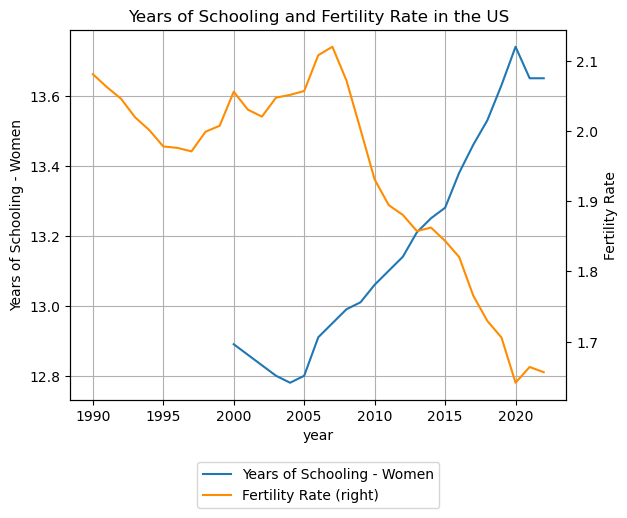

In [5]:
# Reads the csv file and saves it to the female_education variable
female_education = pd.read_csv("female_education.csv")
# Reformats the female_education table so that each year represents a row within a column "year"
us = female_education.loc[female_education["ISO_Code"] == "USA"].copy()
femal = female_education.loc[female_education["ISO_Code"] == "USA"].copy()
year_cols = [c for c in us.columns if str(c).isdigit()]
us_years = us[year_cols]
us_t = us_years.T
us_t = us_t.reset_index()
us_t.columns = ["year", "education"]   # rename the value column to whatever this dataset represents
us_t["year"] = us_t["year"].astype(int)
us_t.head()
female_education = us_t
# Reads the csv file and saves it to the fertility_rate variable
fertility_rate = pd.read_csv("fertility_rate.csv")
# Extracts the year from the year-month-day format in the csv
fertility_rate['year'] = pd.to_datetime(fertility_rate['observation_date']).dt.year
# Groups each year by the average employment rate over different dates
fertility_rate = fertility_rate.groupby('year')['SPDYNTFRTINUSA'].mean()
fertility_rate = (
    fertility_rate
    .reset_index()
    .rename(columns={"LNS11300002": "employment_rate"})
)
# Combines fertility rate and employment tables
edu_and_fertile = pd.merge(
    female_education,
    fertility_rate,
    on=["year"]
)
# Cleans up the data so that it only includes years where there is data for both education and employment
clean = edu_and_fertile.dropna(subset=["education", "SPDYNTFRTINUSA"])
clean.head()

# Generates the graph
ax = edu_and_fertile.plot(
    x='year',
    y='education',
    label='Years of Schooling - Women'
)

edu_and_fertile.plot(
    x='year',
    y='SPDYNTFRTINUSA',
    secondary_y=True,
    ax=ax,
    label='Fertility Rate',
    color='darkorange'
)

ax.set_ylabel('Years of Schooling - Women')
ax.right_ax.set_ylabel('Fertility Rate')

ax.set_title('Years of Schooling and Fertility Rate in the US')
ax.grid(True)

# Combine legends from both axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2)
ax.legend(lines_1 + lines_2, labels_1 + labels_2,loc='upper center', bbox_to_anchor=(0.5, -0.15))

plt.show()

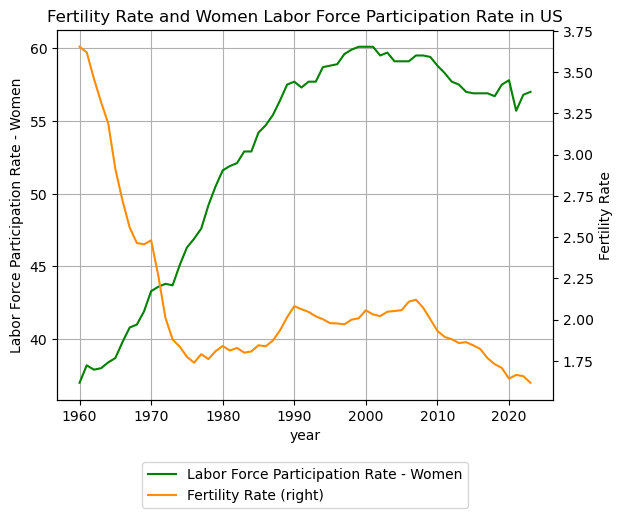

In [6]:
labor = pd.read_csv('LNS11300002.csv')
labor
fertility = pd.read_csv('fertility_rate.csv')
fertility
df = pd.merge(fertility, labor)
df
df['year'] = df['observation_date'].str[:4].astype(int)
df.drop(columns = 'observation_date')
ax.plot(df['year'], df['SPDYNTFRTINUSA'], label='Fertility Rate', marker='o') 
ax.plot(df['year'], df['LNS11300002'], label='Labor Force Participation Rate - Women', linestyle='--') 
ax = df.plot(
    x='year',
    y='LNS11300002',
    label='Labor Force Participation Rate - Women',
    color='green'
)

df.plot(
    x='year',
    y='SPDYNTFRTINUSA',
    secondary_y=True,
    ax=ax,
    label='Fertility Rate',
    color='darkorange'
)

ax.set_ylabel('Labor Force Participation Rate - Women')
ax.right_ax.set_ylabel('Fertility Rate')

ax.set_title('Fertility Rate and Women Labor Force Participation Rate in US')
ax.grid(True)

# Combine legends from both axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2)
ax.legend(lines_1 + lines_2, labels_1 + labels_2,loc='upper center', bbox_to_anchor=(0.5, -0.15))

plt.show()

# Population Function

To support our analysis we define a function that returns population date for a given year, age range, sex, and country. The function will respond to queries of the following form: 

"In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?"

In [7]:
def get_population_dataframe(country_codes=["USA"]):
    """
    Downloads population breakdown (age/sex) for specified countries.
    Returns a clean DataFrame indexed by Country and Year with human-readable columns.
    """
    # 1. Construct the Mapping Dictionary
    # We define the code mapping here so we can use it to rename columns later
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }

    # Generate codes for both sexes
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start, mid in ages.items():
            wb_code = f"SP.POP.{mid}{suffix}"
            
            # Format: "Male 0-4", "Female 80UP"
            if start == 80:
                name = f"{sex} 80UP"
            else:
                name = f"{sex} {start}-{start+4}"
            
            variable_labels[wb_code] = name

    # 2. Fetch Data
    print(f"Downloading data for: {country_codes}...")
    df = wbdata.get_dataframe(variable_labels, country=country_codes)
    
    # 3. Data Cleaning
    df = df.rename(columns=variable_labels)
    
    # Reset index to handle "Date" and "Country" columns reliably
    df = df.reset_index()
    
    # Standardize column names (lowercase)
    df.columns = [c.lower() if c in ['country', 'date'] else c for c in df.columns]
    
    # If fetching a single country, wbdata might drop the 'country' column. Add it back.
    if 'country' not in df.columns:
        # Use the first code provided if singular
        c_name = country_codes[0] if isinstance(country_codes, list) else country_codes
        df['country'] = c_name

    # Convert Date to Integer
    df['date'] = df['date'].astype(int)
    
    # Set final MultiIndex
    return df.set_index(['country', 'date']).sort_index()
_POP_DF_CACHE = None

def population(year=2020, sex="People", age_range=(0, 100), place="USA"):
    global _POP_DF_CACHE
    
    if _POP_DF_CACHE is None:
        _POP_DF_CACHE = get_population_dataframe([place])
    
    df = _POP_DF_CACHE
    row = df.loc[(place, year)]
    low, high = age_range

    cols = []
    for c in row.index:
        c_sex, age = c.split()
        
        if age == "80UP":
            a, b = 80, 200
        else:
            a, b = map(int, age.split("-"))
            b += 1
        
        if a < high and b > low and (sex == "People" or c_sex == sex):
            cols.append(c)

    return int(row[cols].sum())


After defining our function, our team used it to identify population data about our years of interest, 1960 vs 2024.

In [8]:
population(year=2024,sex="People",age_range=(15,64),place="USA")

220210618

In [9]:
population(year=2024,sex="Female",age_range=(15,64),place="USA")

107503334

In [10]:
population(year=2024,sex="Male",age_range=(15,64),place="USA")

112707284

In [11]:
population(year=1960,sex="People",age_range=(15,64),place="USA")

108228090

In [12]:
population(year=1960,sex="Female",age_range=(15,64),place="USA")

55181339

In [13]:
population(year=1960,sex="Male",age_range=(15,64),place="USA")

53046751

# Population Models Analysis

The economic downturn of the 1970s pushed more women into the workforce, so we selected the years of **1960** and **2024** to focus on in order to study labor force participation and on US population composition leading up to the 1970s recession and now in present-day.

The typical working age is 15-64. Per our above population function, the number of women who were working age in 1960 was 55,181,339 of 108,228,090 total people in this age range. This means women made up 50.99% of the working age in 1960. However, in 1960, only **32.87%** of the labor force were women (22,666,000 of 68,962,000 total) which can be explained by the **38%** woman labor force participation rate, compared to the **83%** male labor force participation rate, per our labor force participation rate function.

In 2024, per our population function, women make up 48.82% of the working age population in the US (107,503,334 women aged 15-64 of 22,021,0618 total working-age people). Far closer to the working-age population percentage, women made up **47%** of the labor force (78,757,000 women of 167,308,000 total). This is explained by the increased female labor force participation rate, **58%**, and the decreased male labor force participation rate, **68%**.

After recognizing these large shifts in labor force composition and participation by gender, we analyzed major shifts in the population during 1960 and 2024 that we believe to have been impacted by the changing social roles.

## Population Pyramids

--- TESTING SINGLE ESTIMATES ---
Total USA Population (2020): 331,577,719
Teenage Boys (15-19) in 2015:  10,830,494
Women 80+ in 1990:             4,766,778


--- DOWNLOADING DATA FRAME ---

Preview of the data (First 5 rows):
               Male 0-4    Male 5-9  Male 10-14  Male 15-19  Male 20-24  \
country date                                                              
USA     2024  9344629.0  10134460.0  10741858.0  11546654.0  11502398.0   
        2023  9350284.0  10223503.0  10827626.0  11425546.0  11336593.0   
        2022  9397751.0  10294733.0  10962865.0  11306513.0  11287667.0   
        2021  9497997.0  10344156.0  11098563.0  11192474.0  11254043.0   
        2020  9699985.0  10409336.0  11213523.0  11173365.0  11257304.0   

              Male 25-29  Male 30-34  Male 35-39  Male 40-44  Male 45-49  ...  \
country date                                                              ...   
USA     2024  11506900.0  12390220.0  12123824.0  11672354.0  10589298.0  ...   
    

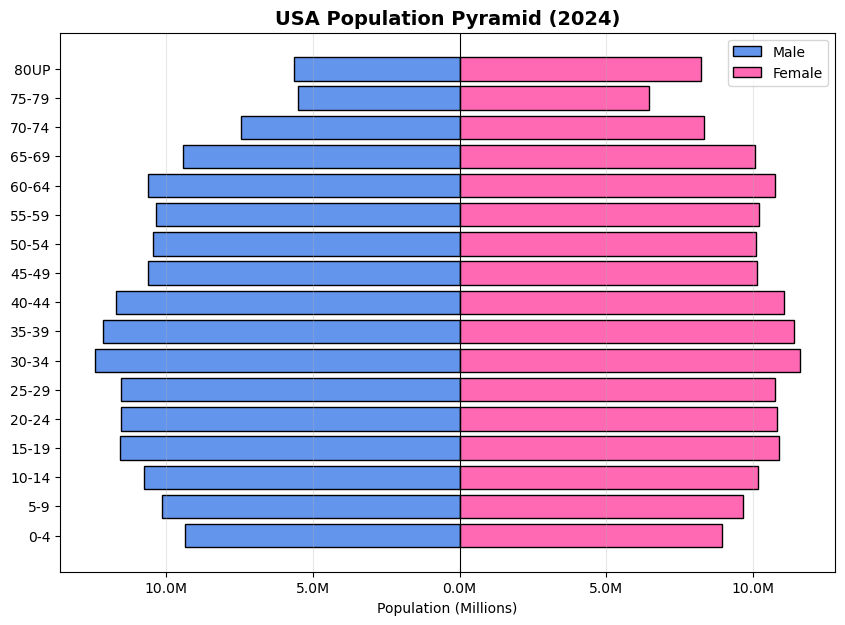

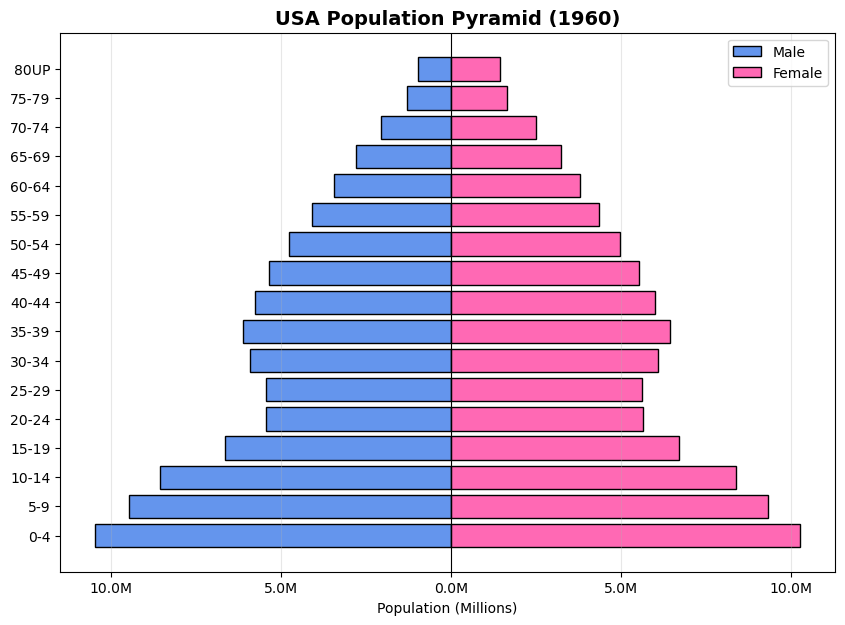

In [14]:
def get_population_dataframe(country_codes=["USA"]):
    """
    Downloads population breakdown (age/sex) for specified countries.
    Returns a clean DataFrame indexed by Country and Year with human-readable columns.
    """
    # 1. Construct the Mapping Dictionary
    # We define the code mapping here so we can use it to rename columns later
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }

    # Generate codes for both sexes
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start, mid in ages.items():
            wb_code = f"SP.POP.{mid}{suffix}"
            
            # Format: "Male 0-4", "Female 80UP"
            if start == 80:
                name = f"{sex} 80UP"
            else:
                name = f"{sex} {start}-{start+4}"
            
            variable_labels[wb_code] = name

    # 2. Fetch Data
    print(f"Downloading data for: {country_codes}...")
    df = wbdata.get_dataframe(variable_labels, country=country_codes)
    
    # 3. Data Cleaning
    df = df.rename(columns=variable_labels)
    
    # Reset index to handle "Date" and "Country" columns reliably
    df = df.reset_index()
    
    # Standardize column names (lowercase)
    df.columns = [c.lower() if c in ['country', 'date'] else c for c in df.columns]
    
    # If fetching a single country, wbdata might drop the 'country' column. Add it back.
    if 'country' not in df.columns:
        # Use the first code provided if singular
        c_name = country_codes[0] if isinstance(country_codes, list) else country_codes
        df['country'] = c_name

    # Convert Date to Integer
    df['date'] = df['date'].astype(int)
    
    # Set final MultiIndex
    return df.set_index(['country', 'date']).sort_index()
def plot_population_pyramid(df, year, country):
    """
    Plots a population pyramid for a specific country and year given a cleaned DataFrame.
    """
    # 1. Select Data
    try:
        data = df.loc[(country, year)]
    except KeyError:
        print(f"Data not available for {country} in {year}")
        return

    # Define age groups in order
    age_groups = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    
    # 2. Prepare Plot Data
    males = [-data[f"Male {age}"] for age in age_groups]
    females = [data[f"Female {age}"] for age in age_groups]
    
    # 3. Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = range(len(age_groups))
    
    # Plot Bars
    ax.barh(y_pos, males, align='center', color='cornflowerblue', label='Male', edgecolor='black', linewidth=0.5)
    ax.barh(y_pos, females, align='center', color='hotpink', label='Female', edgecolor='black', linewidth=0.5)
    
    # 4. Formatting
    # Set Y-axis labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(age_groups)
    
    # Format X-axis to show positive millions (e.g., "2.5M") instead of scientific notation
    def human_format(x, pos):
        return f'{abs(x)*1e-6:.1f}M'
    ax.xaxis.set_major_formatter(FuncFormatter(human_format))
    
    # Add titles and grid
    ax.set_title(f"Population Pyramid: {country} ({year})", fontsize=16, fontweight='bold')
    ax.set_xlabel("Population (Millions)")
    ax.set_ylabel("Age Group")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()
    
    # Draw center line
    ax.axvline(0, color='black', linewidth=0.8)
    
    plt.show()
# 1. Fetch Data (USA Only)
def get_usa_data():
    """Downloads USA population data and cleans it up."""
    print("Downloading USA data...")
    
    # Map ages to database codes
    variable_labels = {}
    ages = {
        0: "0004", 5: "0509", 10: "1014", 15: "1519", 20: "2024",
        25: "2529", 30: "3034", 35: "3539", 40: "4044", 45: "4549",
        50: "5054", 55: "5559", 60: "6064", 65: "6569", 70: "7074",
        75: "7579", 80: "80UP"
    }

    # Create the code list
    for sex, suffix in [("Male", ".MA"), ("Female", ".FE")]:
        for start, mid in ages.items():
            wb_code = f"SP.POP.{mid}{suffix}"
            name = f"{sex} 80UP" if start == 80 else f"{sex} {start}-{start+4}"
            variable_labels[wb_code] = name

    # Fetch! for USA data
    df = wbdata.get_dataframe(variable_labels, country="USA")
    
    # RENAME columns to be human readable
    df = df.rename(columns=variable_labels)
     
    # add 'country' back manually to make it match the plotter.
    df = df.reset_index()
    df['date'] = df['date'].astype(int)
    df['country'] = "USA"  # Force the name to match our request
    
    return df.set_index(['country', 'date'])

# 2. Plotting Function
def plot_usa_pyramid(df, year):
    # Grab data for USA + Year
    try:
        data = df.loc[("USA", year)]
    except KeyError:
        print(f"Data missing for {year}")
        return

    # Organize values
    age_groups = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    males = [-data[f"Male {age}"] for age in age_groups]
    females = [data[f"Female {age}"] for age in age_groups]
    
    # Draw Plot
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(age_groups, males, label='Male', color='cornflowerblue', edgecolor='black')
    ax.barh(age_groups, females, label='Female', color='hotpink', edgecolor='black')
    
    # Format 'Millions' on X-axis
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{abs(x)/1e6:.1f}M'))
    
    ax.set_title(f"USA Population Pyramid ({year})", fontsize=14, fontweight='bold')
    ax.set_xlabel("Population (Millions)")
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(0, color='black', linewidth=0.8)
    plt.show()
# Test the Single Number Function

print("--- TESTING SINGLE ESTIMATES ---")

# Q1: Total people in the USA in 2020?
total_2020 = population(2020, "People", (0, 100), "USA")
print(f"Total USA Population (2020): {total_2020:,}")

# Q2: How many teenage boys (15-19) in 2015?
teen_boys = population(2015, "Male", (15, 19), "USA")
print(f"Teenage Boys (15-19) in 2015:  {teen_boys:,}")

# Q3: How many elderly women (80+) in 1990?
elderly_women = population(1990, "Female", (80, 150), "USA")
print(f"Women 80+ in 1990:             {elderly_women:,}")
print("\n")

# Test the Data Fetcher
print("--- DOWNLOADING DATA FRAME ---")
usa_data = get_usa_data()

# Show the first 5 rows 
print("\nPreview of the data (First 5 rows):")
print(usa_data.head())
print("\n")

# Test the Graphing Function
print("--- GENERATING PYRAMID GRAPH ---")
plot_usa_pyramid(usa_data, 2024)
plot_usa_pyramid(usa_data, 1960)

By contrasting the population pyramids in 1960 and 2024, we can show how the population composition has changed between the start of our data, when the fertility rate was at its highest point and female labor force participation was at its lowest in 1960, and present-day, when fertility rates are at the lowest and female labor force participation rate has leveled out at a high.

We also designed an animated population pyramid to fully understand what happened during the period we are studying.

In [15]:
def plot_pyramid_slider(df):
    """
    Creates an animated population pyramid for the USA (1960-Today).
    """
    # 1. Prepare the Data
    # Reset index of dataframe so we can access 'date' and 'country' as normal columns
    df_clean = df.reset_index()
    
    # Sort by Date Ascending (1960 -> 2021)
    df_clean['date'] = df_clean['date'].astype(int)
    df_clean = df_clean.sort_values("date", ascending=True)
    
    # 2. "Melt" the Data
    df_long = df_clean.melt(
        id_vars=['date', 'country'], 
        var_name='group', 
        value_name='count'
    )
    
    # Split "Male 0-4" into two columns: "Male" and "0-4"
    df_long[['sex', 'age']] = df_long['group'].str.split(' ', n=1, expand=True)
    
    # 3. The Negative Trick (for the Left side)
    df_long['population'] = df_long.apply(
        lambda row: -row['count'] if row['sex'] == 'Male' else row['count'], 
        axis=1
    )
    
    # 4. Define Age Order
    # Forces the graph to stack 0-4 at bottom, 80+ at top
    age_order = [
        "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
        "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
        "65-69", "70-74", "75-79", "80UP"
    ]
    
    # 5. Draw the Animation
    fig = px.bar(
        df_long,
        y="age",
        x="population",
        color="sex",
        animation_frame="date",       # <--- The Magic Slider
        orientation='h',
        range_x=[-15_000_000, 15_000_000], # Locks the camera so bars don't jump
        category_orders={"age": age_order[::-1]},
        title="USA Population Pyramid Animation",
        color_discrete_map={'Male': 'cornflowerblue', 'Female': 'hotpink'},
        height=800, 
        width=1000
    )
    
    # OPtional clean up labels
    fig.update_layout(
        xaxis_title="Population",
        yaxis_title="Age Group",
        bargap=0.1
    )
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
    fig.show()

# Use the function
plot_pyramid_slider(usa_data)

Along with analyzing the make-up of different age groups from 1960-2024 we also decided to map how gender played a part in US population trends during the period.

📥 Syncing maps... one moment!


/tmp/ipykernel_169/15817608.py:85: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



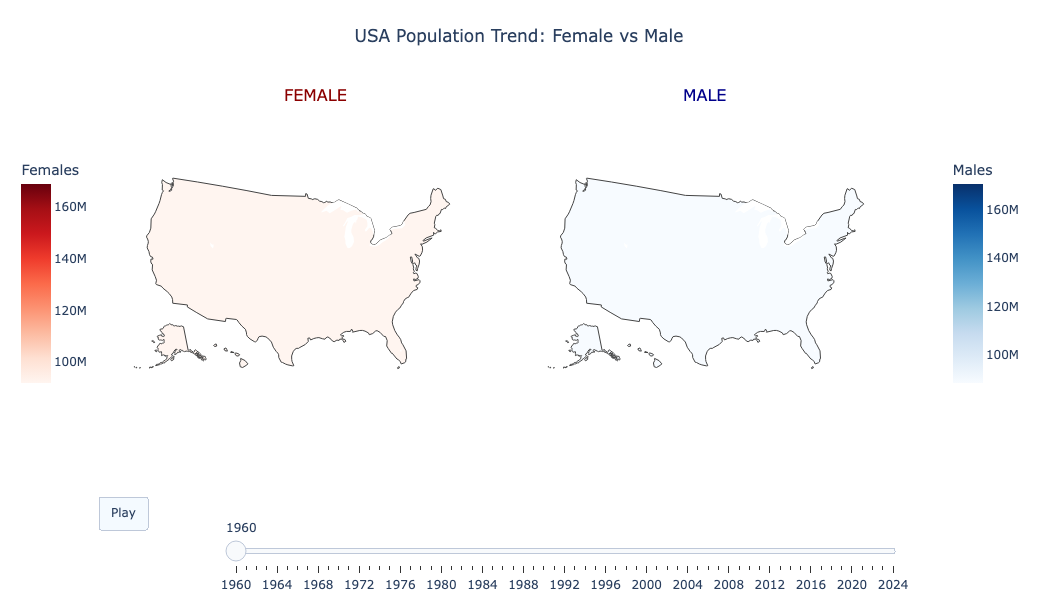

In [16]:
def plot_usa_slider():
    print("📥 Syncing maps... one moment!")
    
    # 1. Fetch Datasets
    indicators = {"SP.POP.TOTL.FE.IN": "Female", "SP.POP.TOTL.MA.IN": "Male"}
    df = wbdata.get_dataframe(indicators, country="USA")
    
    # 2. Clean and Sort
    df.index.name = 'date'
    df = df.reset_index()
    df['date'] = df['date'].astype(int)
    df = df.sort_values("date")
    df['country'] = "United States"

    years = sorted(df['date'].unique())
    
    # 3. Create Animation Frames
    frames = []
    for yr in years:
        yr_data = df[df['date'] == yr]
        frames.append(go.Frame(
            data=[
                # Trace 0: Female Map
                go.Choropleth(
                    locations=yr_data['country'],
                    locationmode="country names",
                    z=yr_data['Female'],
                    colorscale="Reds",
                    colorbar=dict(title="Females", x=-0.12, len=0.7),
                    zmin=df['Female'].min(), zmax=df['Female'].max(),
                    geo='geo'
                ),
                # Trace 1: Male Map
                go.Choropleth(
                    locations=yr_data['country'],
                    locationmode="country names",
                    z=yr_data['Male'],
                    colorscale="Blues",
                    colorbar=dict(title="Males", x=1.05, len=0.7),
                    zmin=df['Male'].min(), zmax=df['Male'].max(),
                    geo='geo2'
                )
            ],
            name=str(yr)
        ))

    # 4. The Alignment Layout
    layout = go.Layout(
        title=dict(text="USA Population Trend: Female vs Male", x=0.5, y=0.95),
        width=1100,
        height=600,
        
        # We set 'y': [0, 1] for to line up the map
        geo=dict(
            scope='north america',
            domain={'x': [0, 0.48], 'y': [0, 1]}, 
            showlakes=True, lakecolor='white',
            projection_type="albers usa" # standard US map projection
        ),
        geo2=dict(
            scope='north america',
            domain={'x': [0.52, 1.0], 'y': [0, 1]}, 
            showlakes=True, lakecolor='white',
            projection_type="albers usa"
        ),
        
        # Annotations for headers
        annotations=[
            dict(text="FEMALE", x=0.22, y=1.05, showarrow=False, font=dict(size=16, color="DarkRed")),
            dict(text="MALE", x=0.78, y=1.05, showarrow=False, font=dict(size=16, color="DarkBlue"))
        ],
        
        updatemenus=[{
            "buttons": [{"args": [None, {"frame": {"duration": 50, "redraw": True}}],
                         "label": "Play", "method": "animate"}],
            "type": "buttons", "x": 0.05, "y": -0.15
        }],
        sliders=[{
            "steps": [{"args": [[f.name], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}],
                       "label": f.name, "method": "animate"} for f in frames],
            "x": 0.15, "len": 0.85, "y": -0.15
        }]
    )

    fig = go.Figure(data=frames[0].data, frames=frames, layout=layout)
    fig.show()

# Run the perfect alignment version
plot_usa_slider()

In [17]:
# lfpr_annual: year, Total, Men, Women
# female_education: year, education
# fertility_rate: year, SPDYNTFRTINUSA

df_reg = (lfpr_annual
          .merge(female_education, on="year", how="inner")
          .merge(fertility_rate[["year", "SPDYNTFRTINUSA"]], on="year", how="inner")
          .dropna()
          .sort_values("year"))

# baseline: separate effects of Men, Women, Education
m1 = smf.ols("SPDYNTFRTINUSA ~ Men + Women + education", data=df_reg).fit(cov_type="HC1")

# optional: does education change the effect of women's participation?
m2 = smf.ols("SPDYNTFRTINUSA ~ Men + Women*education", data=df_reg).fit(cov_type="HC1")

print(m1.summary())
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:         SPDYNTFRTINUSA   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     215.6
Date:                Thu, 12 Feb 2026   Prob (F-statistic):           7.55e-15
Time:                        14:18:59   Log-Likelihood:                 43.571
No. Observations:                  23   AIC:                            -79.14
Df Residuals:                      19   BIC:                            -74.60
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5297      1.262      3.589      0.0

# Conclusion

This regression demonstrates that education is strongly and negatively associated with fertility. This means that years in which women had more schooling tend to have lower fertility rates. 

On the other hand, male and female labor force participation is not statistically significant once education is taken into account, suggesting that education explains for a lot of the relationship we observe between work and fertility. 

A clear pattern can be found by allowing women's labor force participation and education to interact. At lower levels of schooling, increases in women's workforce participation are associated with larger declines in fertility. This indicates a strong tradeoff between working and having children. However, as years of schooling increase the tradeoff becomes weaker. At higher levels of education women appear to be able to combine labor market participation with having children.

The findings from this regression are consistent with the idea of women being forced into the labor market in the 1970s. In the 1970s the need for work was high so many women with fewer years of schooling entered the labor market. In this case there were sharp fertility declines. 

As women’s educational attainment increased, access to more stable and flexible employment improved, reducing the conflict between labor force participation and family life and enabling lasting shifts in women’s economic roles.
